In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall


In [75]:
TRAIN_DIR = '/kaggle/input/car-damage-severity-dataset/data3a/training'
VAL_DIR = '/kaggle/input/car-damage-severity-dataset/data3a/validation'

In [76]:
# Parameters
IMG_SIZE = (224, 224)  # Image dimensions for ResNet50
BATCH_SIZE = 1
NUM_CLASSES = 3  # Minor, Moderate, Severe

In [77]:
# Class labels mapping
CLASS_NAMES = {
    "01-minor": 0,
    "02-moderate": 1,
    "03-severe": 2
}

In [78]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [79]:

# Validation data (rescaling only)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [80]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1383 images belonging to 3 classes.


In [81]:
# Load validation data
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 248 images belonging to 3 classes.


In [82]:
# Check class mapping
print(f"Class Indices: {train_generator.class_indices}")

Class Indices: {'01-minor': 0, '02-moderate': 1, '03-severe': 2}


In [83]:
# Load pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [84]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer


In [85]:

# Define the complete model
model = Model(inputs=base_model.input, outputs=x)


In [89]:
# Suppose that `model` is your neural network model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Utilisez categorical_crossentropy
    metrics=['accuracy', Precision(), Recall()]  # Ajoutez precision et recall
)


# Print model summary
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [90]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
)


Epoch 1/100
1383/1383 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.3734 - loss: 1.1819 - precision_1: 0.4002 - recall_1: 0.1592 - val_accuracy: 0.4153 - val_loss: 1.0335 - val_precision_1: 0.5726 - val_recall_1: 0.2702
Epoch 2/100
1383/1383 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.4367 - loss: 1.0250 - precision_1: 0.5790 - recall_1: 0.1803 - val_accuracy: 0.5323 - val_loss: 0.9468 - val_precision_1: 0.6129 - val_recall_1: 0.3831
Epoch 3/100
1383/1383 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.4781 - loss: 1.0056 - precision_1: 0.5840 - recall_1: 0.2634 - val_accuracy: 0.5766 - val_loss: 0.9106 - val_precision_1: 0.8108 - val_recall_1: 0.2419
Epoch 4/100
1383/1383 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.4677 - loss: 0.9985 - precision_1: 0.5918 - recall_1: 0.2265 - val_accuracy: 0.5645 - val_loss: 0.8931 - val_precision_1: 0.7731 - val_recall_1: 0.3710
Epoch 5/100
1383/1383 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.4885 - loss: 0.9827 - precision_1: 0.

In [91]:
# Save the final model
model.save("car_damage_severity_model_2.h5")

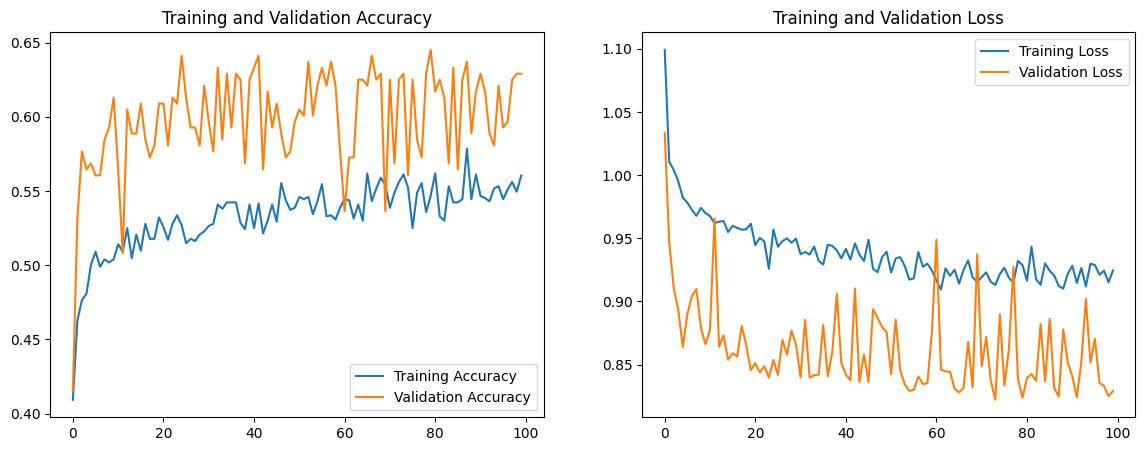

In [92]:
# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()


plot_training_history(history)

In [ ]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


In [ ]:
import numpy as np
import requests
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/car_damage_severity_model.h5')  # Replace with your saved model's filename

# Define class labels (update according to your dataset's classes)
CLASS_NAMES = {
    0: 'Minor Damage',
    1: 'Moderate Damage',
    2: 'Severe Damage'
}

# Function to preprocess the image
def preprocess_image(image_url, target_size=(224, 224)):
    """
    Preprocess an image from URL for prediction.

    Args:
        image_url (str): URL of the image to be processed.
        target_size (tuple): Desired size of the image.

    Returns:
        np.ndarray: Preprocessed image ready for prediction.
    """
    # Download the image from the URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Resize and convert the image to the required format
    img = img.resize(target_size)
    img = np.array(img)  # Convert image to a numpy array
    
    # Normalize the image
    img = img / 255.0

    # Add batch dimension
    img = np.expand_dims(img, axis=0)
    
    return img, img


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Class: Severe Damage
Confidence: 0.68


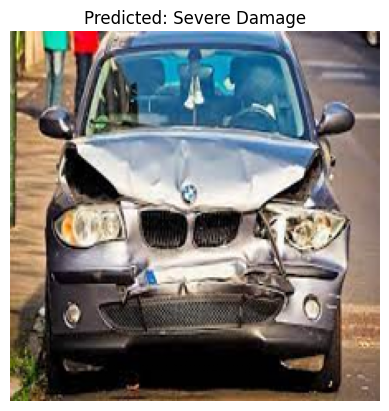

In [99]:
# Path to the test image (URL)
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSfEVH-sOa1ApPet3IBYu0V-S5EE5WDnrSZ3JzqlGU1AE3e_7aEl5_Nww53QtQBQt3snxM&usqp=CAU'  # Replace with the actual image URL

# Preprocess the image
processed_image, original_image = preprocess_image(image_url)

# Predict the class
predictions = model.predict(processed_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Output the result
print(f"Predicted Class: {CLASS_NAMES[predicted_class]}")
print(f"Confidence: {predictions[0][predicted_class]:.2f}")

# Remove the batch dimension for display
original_image = original_image[0]  # This gives the shape (224, 224, 3)

# Show the original image using matplotlib
plt.imshow(original_image)
plt.title(f"Predicted: {CLASS_NAMES[predicted_class]}")
plt.axis('off')  # Hide axis labels
plt.show()
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Class: Minor Damage
Confidence: 0.49


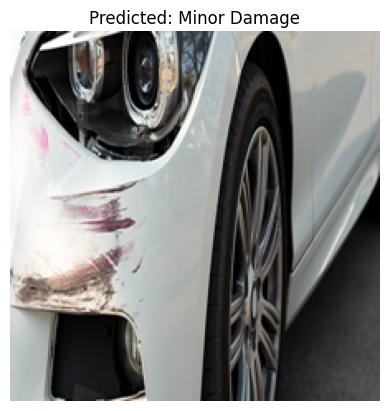

In [100]:
# Path to the test image (URL)
image_url = 'https://www.goodbyecar.uk/uploads/images/cms/original/1621870741DamagedCar.jpg'  # Replace with the actual image URL

# Preprocess the image
processed_image, original_image = preprocess_image(image_url)

# Predict the class
predictions = model.predict(processed_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Output the result
print(f"Predicted Class: {CLASS_NAMES[predicted_class]}")
print(f"Confidence: {predictions[0][predicted_class]:.2f}")

# Remove the batch dimension for display
original_image = original_image[0]  # This gives the shape (224, 224, 3)

# Show the original image using matplotlib
plt.imshow(original_image)
plt.title(f"Predicted: {CLASS_NAMES[predicted_class]}")
plt.axis('off')  # Hide axis labels
plt.show()
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Class: Moderate Damage
Confidence: 0.43


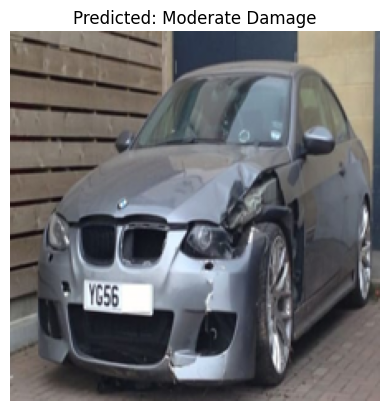

In [101]:
# Path to the test image (URL)
image_url = 'https://gpmetalsandspares.co.uk/wp-content/uploads/2020/01/Scrap-Car-or-Salvage-Car-What-is-the-Difference-1.jpg'  # Replace with the actual image URL

# Preprocess the image
processed_image, original_image = preprocess_image(image_url)

# Predict the class
predictions = model.predict(processed_image)
predicted_class = np.argmax(predictions, axis=1)[0]

# Output the result
print(f"Predicted Class: {CLASS_NAMES[predicted_class]}")
print(f"Confidence: {predictions[0][predicted_class]:.2f}")

# Remove the batch dimension for display
original_image = original_image[0]  # This gives the shape (224, 224, 3)

# Show the original image using matplotlib
plt.imshow(original_image)
plt.title(f"Predicted: {CLASS_NAMES[predicted_class]}")
plt.axis('off')  # Hide axis labels
plt.show()
 